In [13]:
# create x, y, vx, vy tensors of shape (1, 200, 1). x denotes time in 0-1 interval, y is a custom function to act as imaginary sensorimotor data 

import torch

def polynomial_function(x):
    a, b, c, d = (torch.rand(4) - 0.5) * 2 * 5

    data = a*x**3 + b*x**2 +c*x + d
    data = (data - data.min())/(data.max() - data.min() + 0.1) + 0.1
    return data

def create_data(num_steps=200):
    x = torch.linspace(0, 1, num_steps).reshape(1, num_steps, 1)
    y = polynomial_function(x)
    vx = x.clone()
    vy = y.clone()
    return x, y, vx, vy

num = 6

x, y, vx, vy = torch.zeros(num, 200, 1), torch.zeros(num, 200, 1), torch.zeros(num, 200, 1), torch.zeros(num, 200, 1)
for i in range(num):
    x[i], y[i], vx[i], vy[i] = create_data()

aug = torch.cat((x, y), dim=2)  # shape (6, 200, 2)

n_obs, n_tar = 3, 1
# randomly select n_obs points from aug as observations and n_tar points from x as targets
rand_inds = torch.tensor([43, 89, 168, 124])  # torch.randperm(200)[:n_obs+n_tar]
obs = aug[:, rand_inds[:n_obs], :]
tar_x, tar_y = x[:, rand_inds[n_obs:n_obs+n_tar], :], y[:, rand_inds[n_obs:n_obs+n_tar], :]

print(obs.shape, tar_x.shape, tar_y.shape)

torch.Size([6, 3, 2]) torch.Size([6, 1, 1]) torch.Size([6, 1, 1])


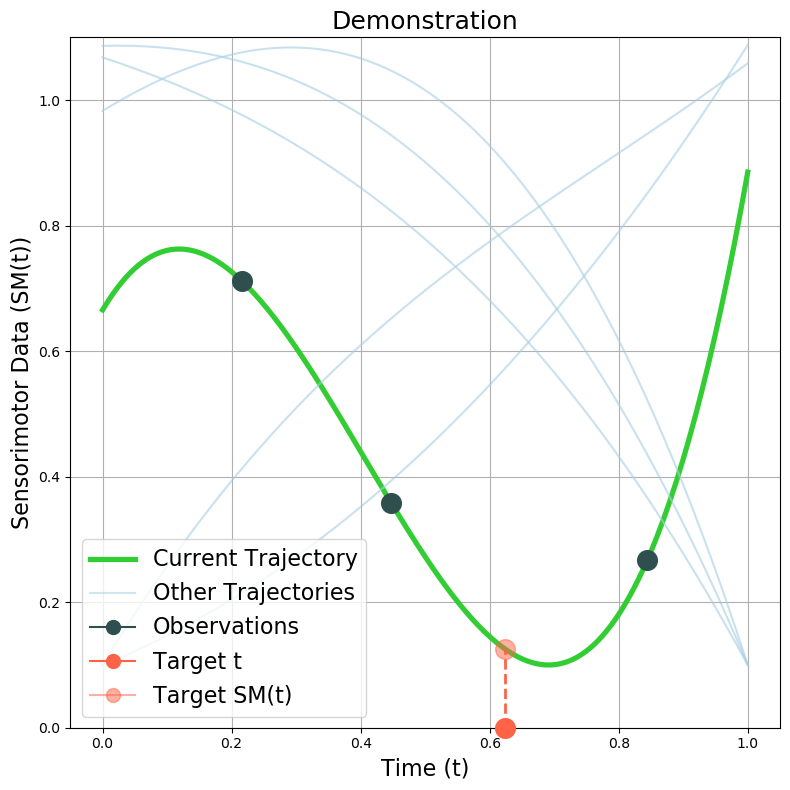

In [19]:
# plot the data
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

palette = sns.color_palette("Paired")

def plot(x, y, obs, tar_x, tar_y):
    # obs: list of observations as x,y pairs
    # tar_x: list of targets as x values

    plt.figure(figsize=(8, 8))

    plt.plot(x[0], y[0], label='Current Trajectory', color='limegreen', linewidth=3.75)

    for i in range(1, num):
        plt.plot(x[i], y[i], color=palette[0], alpha=0.6)

    plt.ylim(0, 1.1)

    scatter_size = 200

    for ob in obs[0]:
        plt.scatter(ob[0], ob[1], marker='o', color='darkslategrey', s=scatter_size, alpha=1, zorder=10)

    n_samp = 100

    for i in range(n_tar):
        plt.scatter(tar_x[0,i,0], 0, marker='o', color='tomato', s=scatter_size, clip_on=False, alpha=1, zorder=10)
        plt.scatter(tar_x[0,i,0], tar_y[0,i,0], marker='o', color='tomato', s=scatter_size, clip_on=False, alpha=0.5, zorder=10)
        plt.plot(tar_x[0, i, 0].repeat(n_samp), torch.linspace(0, tar_y[0, i, 0], n_samp).view(n_samp), color='tomato', linestyle='--', linewidth=2, alpha=1, zorder=10)


    handles, _ = plt.gca().get_legend_handles_labels()
    handles.append(Line2D([0], [0], color=palette[0], label='Other Trajectories', markerfacecolor=palette[0], markersize=10, alpha=0.5))
    handles.append(Line2D([0], [0], marker='o', color='darkslategrey', label='Observations', markerfacecolor='darkslategrey', markersize=10))
    handles.append(Line2D([0], [0], marker='o', color='tomato', label='Target t', markerfacecolor='tomato', markersize=10))
    handles.append(Line2D([0], [0], marker='o', color='tomato', label='Target SM(t)', markerfacecolor='tomato', markersize=10, alpha=0.5))

    plt.xlabel('Time (t)', fontsize=16)
    plt.ylabel('Sensorimotor Data (SM(t))', fontsize=16)
    plt.title('Demonstration', fontsize=18)

    plt.legend(handles=handles, loc='lower left', fontsize=16)
    plt.grid()
    plt.tight_layout()
    plt.show()
    plt.close()

plot(x, y, obs, tar_x, tar_y)

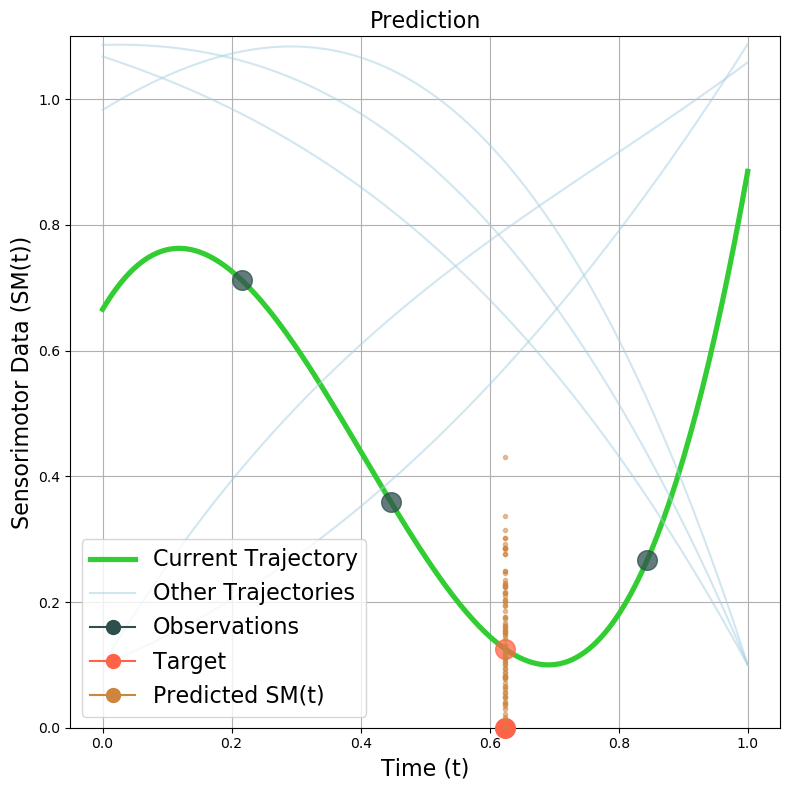

In [23]:
def plot_pred(x, y, obs, tar_x, tar_y, m_y, s_y):
    # obs: list of observations as x,y pairs
    # tar_x: list of targets as x values

    plt.figure(figsize=(8, 8))
    plt.ylim(0, 1.1)

    scatter_size = 200
    alpha_coeff = 0.75

    plt.plot(x[0], y[0], label='Current Trajectory', color='limegreen', linewidth=3.75, alpha=1)

    for i in range(1, num):
        plt.plot(x[i], y[i], color=palette[0], alpha=0.5)

    for ob in obs[0]:
        plt.scatter(ob[0], ob[1], marker='o', color='darkslategrey', s=scatter_size, alpha=1*alpha_coeff, zorder=10)

    n_samp = 100

    for i in range(n_tar):
        plt.scatter(tar_x[0,i,0], 0, marker='o', color='tomato', s=scatter_size, clip_on=False, alpha=1, zorder=10)
        plt.scatter(tar_x[0,i,0], tar_y[0,i,0], marker='o', color='tomato', s=scatter_size, clip_on=False, alpha=alpha_coeff, zorder=10)

        pred_y = torch.distributions.Normal(m_y[i], s_y[i]).sample([n_samp])
        for j in range(n_samp):
            plt.scatter(tar_x[0,i,0], pred_y[j], marker='.', color='peru', alpha=0.5, zorder=10)


    handles, _ = plt.gca().get_legend_handles_labels()
    handles.append(Line2D([0], [0], color=palette[0], label='Other Trajectories', markerfacecolor=palette[0], markersize=10, alpha=0.5))
    handles.append(Line2D([0], [0], marker='o', color='darkslategrey', label='Observations', markerfacecolor='darkslategrey', markersize=10, alpha=1))
    handles.append(Line2D([0], [0], marker='o', color='tomato', label='Target', markerfacecolor='tomato', markersize=10, alpha=1))
    handles.append(Line2D([0], [0], marker='o', color='peru', label='Predicted SM(t)', markerfacecolor='peru', markersize=10, alpha=1))

    plt.xlabel('Time (t)', fontsize=16)
    plt.ylabel('Sensorimotor Data (SM(t))', fontsize=16)
    plt.title('Prediction', fontsize=16)

    plt.legend(handles=handles, loc='lower left', fontsize=16)
    plt.grid()
    plt.tight_layout()
    plt.show()
    plt.close()

my = tar_y.flatten()
plot_pred(x, y, obs, tar_x, tar_y, my, torch.ones_like(my)*0.1)